In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Data Analytics N!/order_details.csv')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")

In [ ]:
#Типы данных
df.dtypes

,0
Order_ID,object
Order_Date,object
Ship_Date,object
Ship_Mode,object
Customer_ID,object
Customer_Name,object
Segment,object
Country,object
City,object
State,object


In [ ]:
# Преобразуем колонку в datetime
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
df['Month'] = df['Order_Date'].dt.month
df['Year'] = df['Order_Date'].dt.year

In [ ]:
df['Order_Date'] = pd.to_datetime(df['Order_Date'])

In [ ]:
mydata = df.groupby('Order_Date')[['Sales', 'Profit', 'Discount']].sum().reset_index()

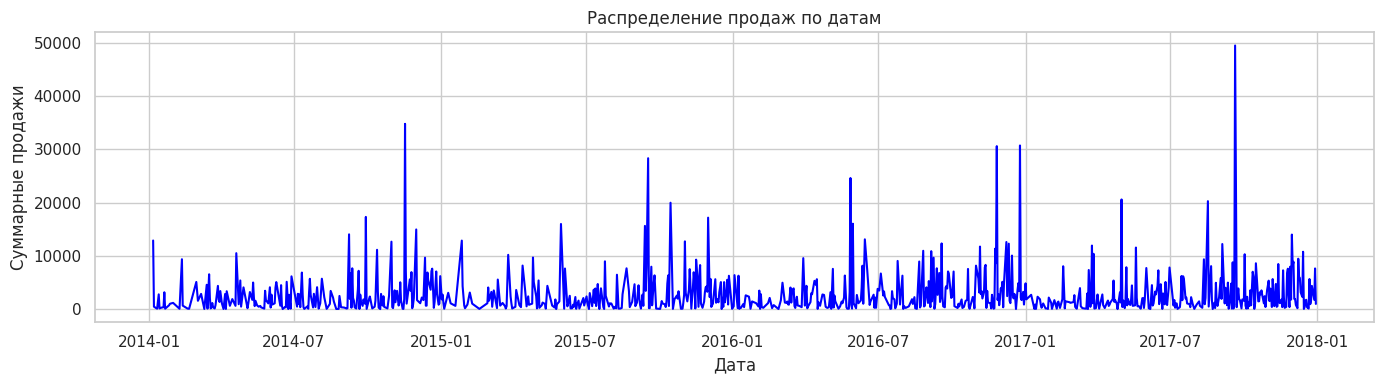

In [ ]:
#Продажи
plt.figure(figsize=(14, 4))
sns.lineplot(data=mydata, x='Order_Date', y='Sales', color='blue')
plt.title('Распределение продаж по датам')
plt.xlabel('Дата')
plt.ylabel('Суммарные продажи')
plt.grid(True)
plt.tight_layout()
plt.show()

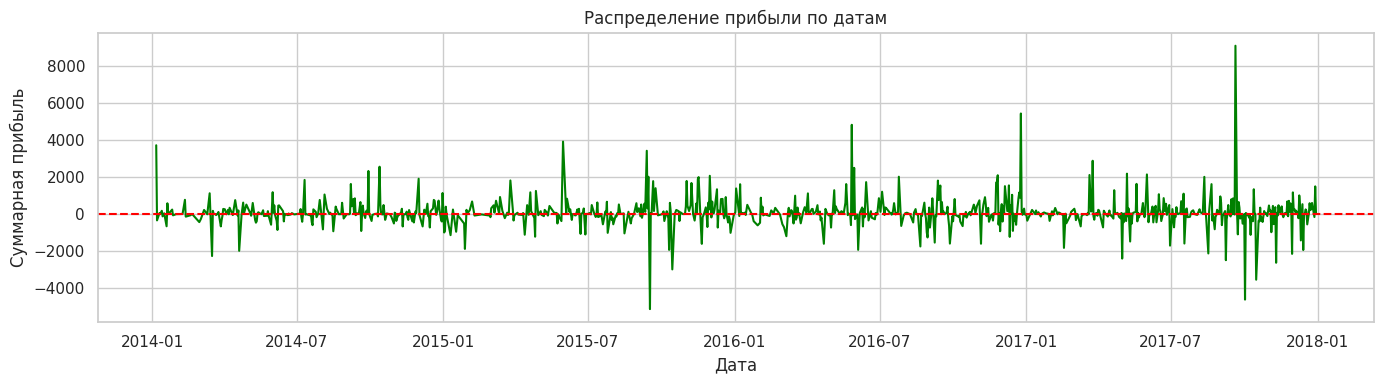

In [ ]:
#Прибыль
plt.figure(figsize=(14, 4))
sns.lineplot(data=mydata, x='Order_Date', y='Profit', color='green')
plt.title('Распределение прибыли по датам')
plt.xlabel('Дата')
plt.ylabel('Суммарная прибыль')
plt.axhline(0, color='red', linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.show()

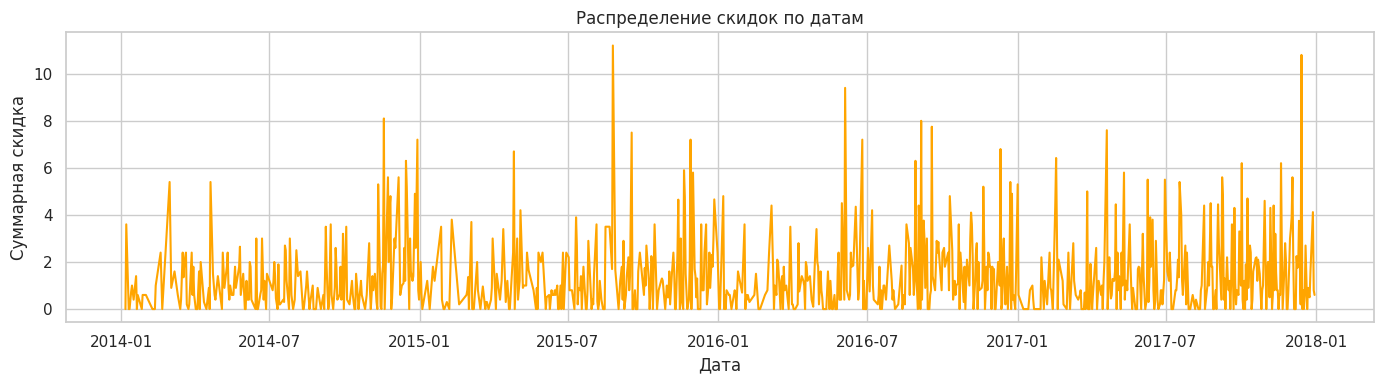

In [ ]:
#Скидки
plt.figure(figsize=(14, 4))
sns.lineplot(data=mydata, x='Order_Date', y='Discount', color='orange')
plt.title('Распределение скидок по датам')
plt.xlabel('Дата')
plt.ylabel('Суммарная скидка')
plt.grid(True)
plt.tight_layout()
plt.show()

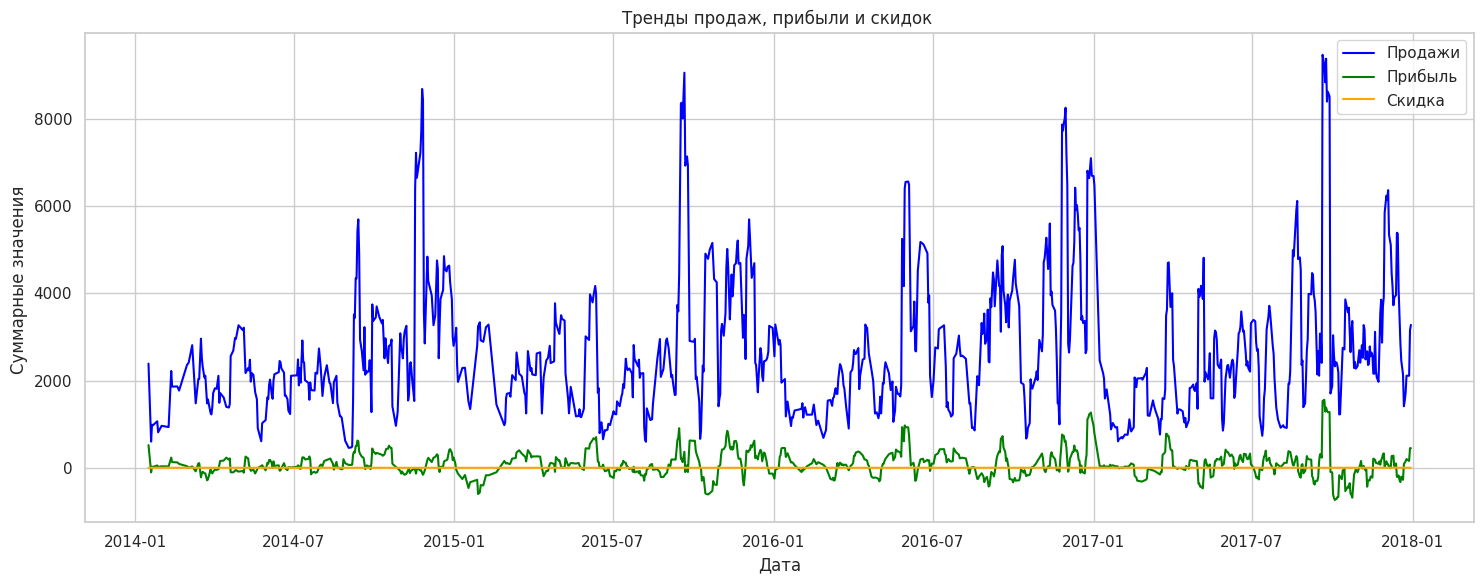

In [ ]:
# Группировка по дате
daily = df.groupby('Order_Date')[['Sales', 'Profit', 'Discount']].sum().reset_index()

# Применим скользящее среднее (на 7 дней)
daily['Sales_smooth'] = daily['Sales'].rolling(window=7).mean()
daily['Profit_smooth'] = daily['Profit'].rolling(window=7).mean()
daily['Discount_smooth'] = daily['Discount'].rolling(window=7).mean()

# Построим график
plt.figure(figsize=(15, 6))
sns.lineplot(x='Order_Date', y='Sales_smooth', data=daily, label='Продажи', color='blue')
sns.lineplot(x='Order_Date', y='Profit_smooth', data=daily, label='Прибыль', color='green')
sns.lineplot(x='Order_Date', y='Discount_smooth', data=daily, label='Скидка', color='orange')

plt.title('Тренды продаж, прибыли и скидок ')
plt.xlabel('Дата')
plt.ylabel('Суммарные значения ')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


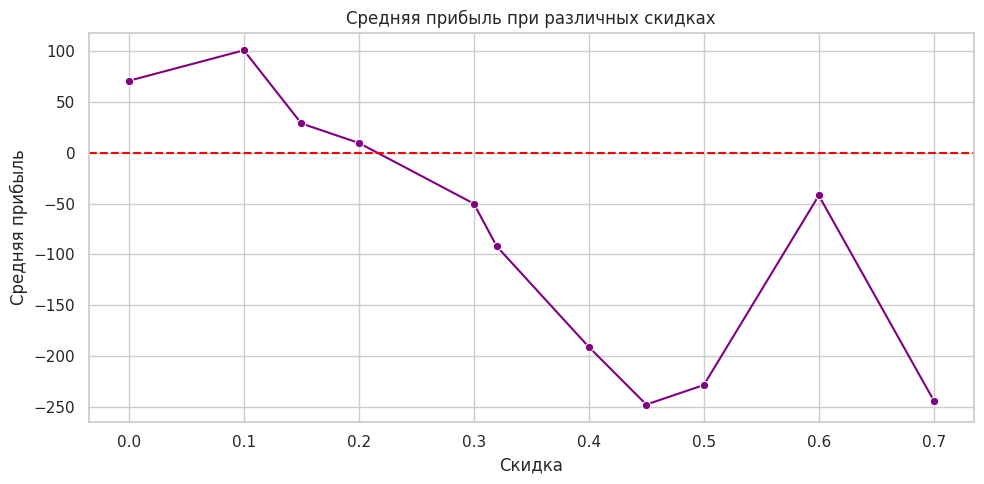

In [ ]:
discount_profit = df.groupby('Discount')['Profit'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=discount_profit, x='Discount', y='Profit', marker='o', color='purple')
plt.title('Средняя прибыль при различных скидках')
plt.xlabel('Скидка')
plt.ylabel('Средняя прибыль')
plt.axhline(0, linestyle='--', color='red')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
corr = df[['Discount', 'Profit']].corr()
print("Корреляция между скидкой и прибылью:")
corr

Корреляция между скидкой и прибылью:


,Discount,Profit
Discount,1.000000,-0.478304
Profit,-0.478304,1.000000


In [ ]:
#Linear Regression Model
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Выбираем нужные признаки
features = ['Sales', 'Discount', 'Quantity']
target = 'Profit'

# Удалим пропущенные значения
df_model = df[features + [target]].dropna()

# Признаки и целевая переменная
X = df_model[features]
y = df_model[target]

In [ ]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [ ]:
# Коэффициенты модели
coefficients = pd.DataFrame({
    'Признак': features,
    'Коэффициент': model.coef_
})
print(coefficients)

    Признак  Коэффициент
0     Sales     0.057770
1  Discount  -338.482361
2  Quantity     0.230205


In [ ]:
df['profit_pred'] = model.predict(df[features])

In [ ]:
df.to_csv('/content/drive/MyDrive/Data Analytics N!/forecast.csv', index=False)

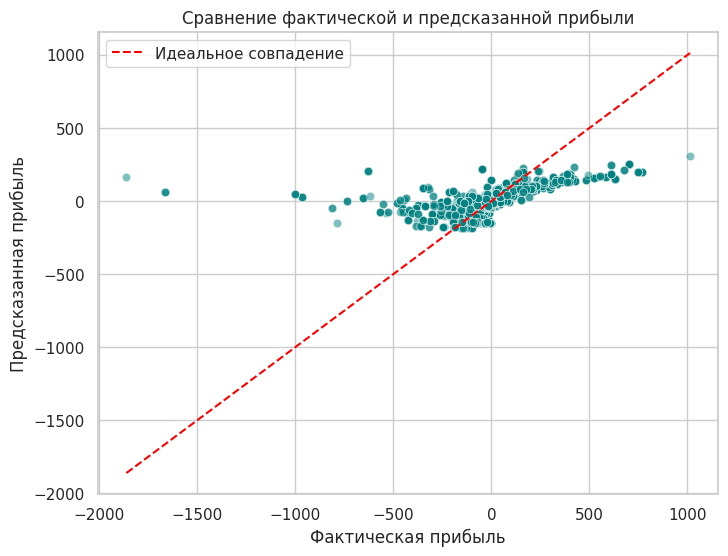

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Profit'], y=df['profit_pred'], alpha=0.5, color='teal')
plt.plot([df['Profit'].min(), df['Profit'].max()],
         [df['Profit'].min(), df['Profit'].max()],
         color='red', linestyle='--', label='Идеальное совпадение')

plt.xlabel('Фактическая прибыль')
plt.ylabel('Предсказанная прибыль')
plt.title('Сравнение фактической и предсказанной прибыли')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Удалим выбросы по правилу IQR
Q1 = df['Profit'].quantile(0.25)
Q3 = df['Profit'].quantile(0.75)
IQR = Q3 - Q1

# Фильтруем только адекватные значения
df_clean = df[(df['Profit'] >= Q1 - 1.5 * IQR) & (df['Profit'] <= Q3 + 1.5 * IQR)]

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

X = df_clean[['Sales', 'Discount', 'Quantity']]
y = df_clean['Profit']

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Делим данные
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Обучаем модель
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)

# Оценки качества модели
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Выводим результаты
print("MSE:", mse)
print("RMSE:", rmse)
print("R2:", r2)


MSE: 49.3723466007307
RMSE: 7.0265458513220205
R2: 0.9530435670313302


In [ ]:
df_clean['profit_pred'] = model.predict(X_poly)

# Сохраняем
df_clean.to_csv('/content/drive/MyDrive/Data Analytics N!/forecast_improved.csv', index=False)

/tmp/ipython-input-70-1598723170.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['profit_pred'] = model.predict(X_poly)


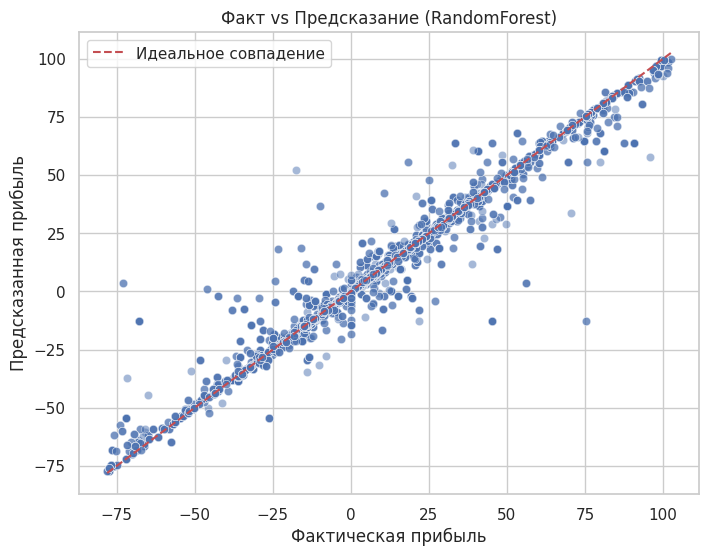

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y, y=model.predict(X_poly), alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Идеальное совпадение')
plt.xlabel('Фактическая прибыль')
plt.ylabel('Предсказанная прибыль')
plt.title('Факт vs Предсказание (RandomForest)')
plt.legend()
plt.grid(True)
plt.show()